In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patch 
import cv2
import numpy as np
import matplotlib.image as mpimg
import math
import sys
import os
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter
from scipy import signal as sig
from tqdm import tqdm
from numpy import linalg as LA

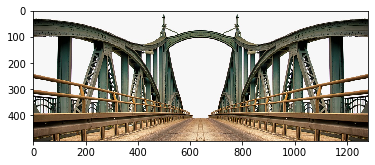

In [2]:
temp_image = cv2.imread('sift.jpeg')
colour_image = cv2.cvtColor(temp_image,cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(temp_image,cv2.COLOR_BGR2GRAY)
plt.imshow(colour_image)

In [3]:
image.shape

(498, 1280)

In [4]:
def resize_image(img,scale,sigma):
    row,col = image.shape
    row = int(row*scale)
    col = int(col*scale)
    dim = (col,row)
    resizeI = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    resizeI = cv2.GaussianBlur(resizeI, (5,5), sigma)
    return resizeI

In [5]:
def generate_octaves(image,octaves,levels,scale,sigma):
    oct_dict = {}
    for i in tqdm(range(1, octaves+1)):
        octs = {}
        resizeI = resize_image(image,scale,sigma)
        octs[1] = resizeI
        scale /= 2
        g = resizeI
        root2 = math.sqrt(2)
        oct_sig = sigma*root2
        for j in range(2, levels+1):
            g = cv2.GaussianBlur(g, (5,5), oct_sig)
            octs[j] = g
            oct_sig = oct_sig*root2
        oct_dict[i] = octs
        sigma = sigma*2
    return oct_dict

In [6]:
oct_dict = generate_octaves(colour_image,4,5,1,1.6)

100%|██████████| 4/4 [00:00<00:00, 249.38it/s]


In [7]:
def generate_DOG():
    DOGs = {}
    for each_octave in oct_dict:
        each_dog = {}
        for i in range(1, len(oct_dict[each_octave])):
            each_dog[i] = oct_dict[each_octave][i+1] - oct_dict[each_octave][i]
        DOGs[each_octave] = each_dog
    return DOGs

In [8]:
DOG = generate_DOG()

Octave :  1
DOG Level:  1


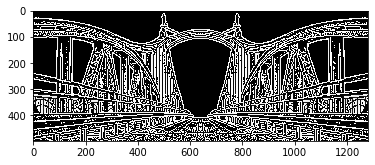

DOG Level:  2


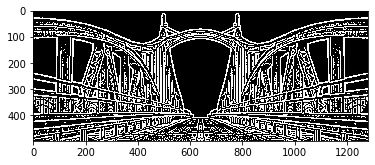

DOG Level:  3


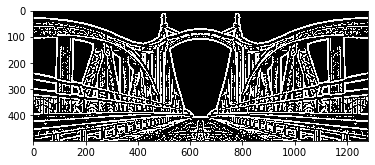

DOG Level:  4


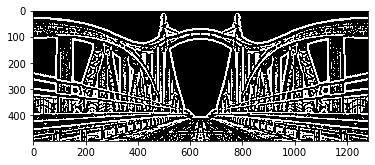

Octave :  2
DOG Level:  1


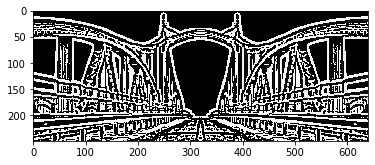

DOG Level:  2


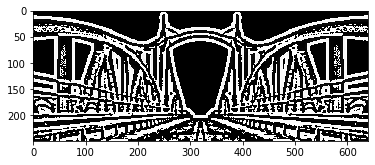

DOG Level:  3


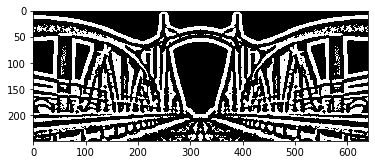

DOG Level:  4


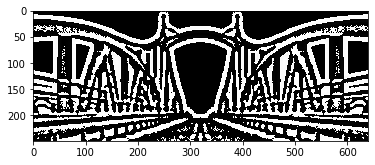

Octave :  3
DOG Level:  1


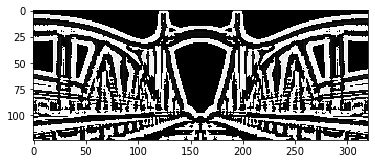

DOG Level:  2


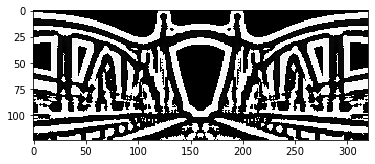

DOG Level:  3


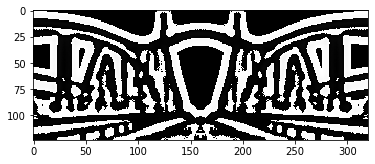

DOG Level:  4


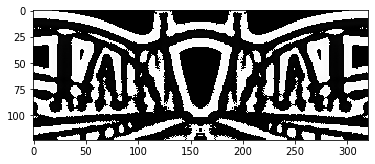

Octave :  4
DOG Level:  1


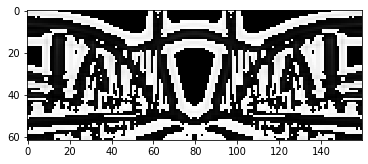

DOG Level:  2


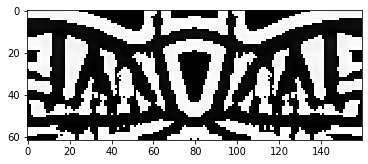

DOG Level:  3


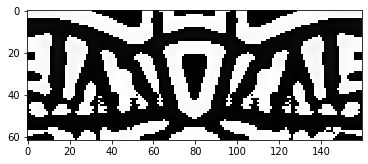

DOG Level:  4


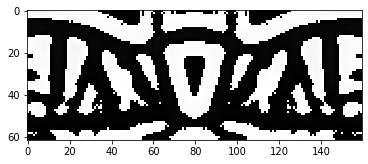

In [9]:
for each_oct in DOG:
    for level in DOG[each_oct]:
        plt.imshow(DOG[each_oct][level], cmap='gray')
        plt.show()

(Text(0.5, 1.0, 'DOG4'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

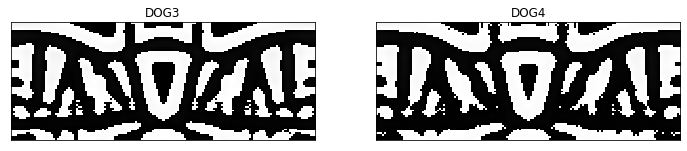

In [10]:
plt.figure(figsize=(12,10))
plt.subplot(121),plt.imshow(DOG[4][3],cmap = 'gray')
plt.title('DOG3'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(DOG[4][4],cmap = 'gray')
plt.title('DOG4'), plt.xticks([]), plt.yticks([])

In [12]:
def shi_thomsi(gx,gy,off):
    Ixy=gx*gy
    Ixx=gx**2
    Iyy=gy**2
    R = np.zeros((gx.shape))
    for y in tqdm(range(off, gx.shape[0] - off-1)):
        for x in range(off, gx.shape[1] - off-1):
            Ixx_patch = Ixx[y-off : y+off+1, x-off : x+off+1]
            Iyy_patch = Iyy[y-off : y+off+1, x-off : x+off+1]
            Ixy_patch = Ixy[y-off : y+off+1, x-off : x+off+1]
            
            Sxx = Ixx_patch.sum()
            Syy = Iyy_patch.sum()
            Sxy = Ixy_patch.sum()
        
            M = [[Sxx,Sxy], [Sxy,Syy]]
            M = np.asarray(M)
            w, v = LA.eig(M)
            r2 = min(w)
            R[y][x] = r2
    return R

In [13]:
def detection_key_points():
    key_points = {}
    window = 9
    for each_octave in tqdm(DOG):
        print("Window size : ", window)
        off = int(window/2)
        print("each_octave : ",each_octave)
        sift_octave_pts = {}
        DOG[each_octave] = DOG[each_octave]
        for each_level in tqdm(range(2, len(DOG[each_octave]))):
            print("DOG level : ",each_level)
            points = []
            gx = np.zeros((DOG[each_octave][each_level].shape))
            gy = np.zeros((DOG[each_octave][each_level].shape))
            img_points = []
            curr = DOG[each_octave][each_level]
            prev = DOG[each_octave][each_level-1]
            nex = DOG[each_octave][each_level+1]
            for x in tqdm(range(off, curr.shape[0]-off-1)):
                for y in range(off, curr.shape[1]-off-1):
                    neighbours = []
                    gx[x,y] = DOG[each_octave][each_level][x+1][y] - DOG[each_octave][each_level][x][y]
                    gy[x,y] = DOG[each_octave][each_level][x][y+1] - DOG[each_octave][each_level][x][y]
                    patch = curr[x-off:x+off+1, y-off:y+off+1]
                    patch = np.asarray(patch)
                    flat_patch = patch.flatten()
                    neighbours.extend(flat_patch)

                    patch_1 = prev[x-off:x+off+1, y-off:y+off+1]
                    flat_patch1 = patch_1.flatten()
                    neighbours.extend(flat_patch1)

                    patch_2 = nex[x-off:x+off+1, y-off:y+off+1]
                    flat_patch2 = patch_2.flatten()
                    neighbours.extend(flat_patch2)

                    pixel_value = curr[x,y]

                    curr_max = patch.max()
                    prev_max = patch_1.max()
                    next_max = patch_2.max()
                    max_among_all = max(curr_max,prev_max,next_max)

                    curr_min = patch.min()
                    prev_min = patch_1.min()
                    next_min = patch_2.min()
                    min_among_all = min(curr_min,prev_min,next_min)

                    local_minima = False
                    local_maxima = False
                    if (pixel_value>=max_among_all):
                        local_maxima = True
                    if (pixel_value<=min_among_all):
                        local_maxima = True

                    if local_minima or local_maxima:
                        points.append((x,y))

            R = shi_thomsi(gx, gy, off)        
            R_max=np.amax(R)
            print(R_max)
            thresh = R_max*0.4
            for i,j in points:
                if R[i,j]>thresh:
                    img_points.append((i,j))
            sift_octave_pts[each_level] = img_points

        key_points[each_octave] = sift_octave_pts
        window=window - 2
    return key_points


In [14]:
key_points = detection_key_points()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 1/489 [00:00<00:52,  9.28it/s]

Window size :  9
each_octave :  1
DOG level :  2




  0%|          | 2/489 [00:00<00:52,  9.27it/s]

  1%|          | 4/489 [00:00<00:48,  9.99it/s]

  1%|          | 6/489 [00:00<00:43, 11.13it/s]

  1%|▏         | 7/489 [00:00<00:46, 10.42it/s]/home/surbhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
/home/surbhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


  2%|▏         | 9/489 [00:00<00:43, 11.12it/s]

  2%|▏         | 11/489 [00:00<00:42, 11.27it/s]

  3%|▎         | 13/489 [00:01<00:45, 10.53it/s]

  3%|▎         | 15/489 [00:01<00:43, 10.91it/s]

  3%|▎         | 17/489 [00:01<00:40, 11.59it/s]

  4%|▍         | 19/489 [00:01<00:41, 11.23it/s]

  4%|▍         | 21/489 [00:01<00:40, 11.63it/s]

  5%|▍         | 23/489 [00:01<00:39, 11.70it/s]

  5%|▌         | 25/489 [00:02<00:39, 11.82it/s]

  6%|▌         | 27/489 [00:02<00:39, 11.71it/s]

  6%|▌         | 29/489 [00:02<00:37, 12.

 16%|█▌        | 77/489 [00:06<00:35, 11.60it/s]

 16%|█▌        | 79/489 [00:06<00:35, 11.42it/s]

 17%|█▋        | 81/489 [00:06<00:35, 11.49it/s]

 17%|█▋        | 83/489 [00:07<00:34, 11.85it/s]

 17%|█▋        | 85/489 [00:07<00:34, 11.66it/s]

 18%|█▊        | 87/489 [00:07<00:34, 11.56it/s]

 18%|█▊        | 89/489 [00:07<00:33, 11.87it/s]

 19%|█▊        | 91/489 [00:07<00:33, 11.77it/s]

 19%|█▉        | 93/489 [00:07<00:34, 11.59it/s]

 19%|█▉        | 95/489 [00:08<00:33, 11.70it/s]

 20%|█▉        | 97/489 [00:08<00:33, 11.80it/s]

 20%|██        | 99/489 [00:08<00:33, 11.78it/s]

 21%|██        | 101/489 [00:08<00:32, 11.85it/s]

 21%|██        | 103/489 [00:08<00:33, 11.68it/s]

 21%|██▏       | 105/489 [00:08<00:32, 11.71it/s]

 22%|██▏       | 107/489 [00:09<00:33, 11.46it/s]

 22%|██▏       | 109/489 [00:09<00:32, 11.71it/s]

 23%|██▎       | 111/489 [00:09<00:32, 11.77it/s]

 23%|██▎       | 113/489 [00:09<00:31, 11.86it/s]

 24%|██▎       | 115/489 [00:09<00:31, 11.7

2395261.964977069
DOG level :  3




  0%|          | 2/489 [00:00<00:36, 13.41it/s]

  1%|          | 3/489 [00:00<00:40, 11.88it/s]

  1%|          | 5/489 [00:00<00:38, 12.58it/s]

  1%|▏         | 7/489 [00:00<00:37, 12.79it/s]

  2%|▏         | 9/489 [00:00<00:36, 13.15it/s]

  2%|▏         | 11/489 [00:00<00:36, 13.15it/s]

  3%|▎         | 13/489 [00:00<00:36, 13.13it/s]

  3%|▎         | 15/489 [00:01<00:35, 13.46it/s]

  3%|▎         | 17/489 [00:01<00:35, 13.17it/s]

  4%|▍         | 19/489 [00:01<00:35, 13.19it/s]

  4%|▍         | 21/489 [00:01<00:34, 13.68it/s]

  5%|▍         | 23/489 [00:01<00:35, 13.02it/s]

  5%|▌         | 25/489 [00:01<00:36, 12.78it/s]

  6%|▌         | 27/489 [00:02<00:36, 12.67it/s]

  6%|▌         | 29/489 [00:02<00:35, 13.08it/s]

  6%|▋         | 31/489 [00:02<00:33, 13.53it/s]

  7%|▋         | 33/489 [00:02<00:33, 13.50it/s]

  7%|▋         | 35/489 [00:02<00:32, 13.88it/s]

  8%|▊         | 37/489 [00:02<00:32, 13.73it/s]

  8%|▊         | 39/489 [00:02<00:31, 14.21it/s]

  8

 14%|█▎        | 67/489 [00:07<00:52,  8.01it/s]

 14%|█▍        | 68/489 [00:07<00:51,  8.22it/s]

 14%|█▍        | 70/489 [00:07<00:46,  8.93it/s]

 15%|█▍        | 72/489 [00:07<00:43,  9.60it/s]

 15%|█▍        | 73/489 [00:07<00:50,  8.28it/s]

 15%|█▌        | 74/489 [00:07<00:51,  8.07it/s]

 15%|█▌        | 75/489 [00:07<00:49,  8.31it/s]

 16%|█▌        | 77/489 [00:08<00:45,  9.10it/s]

 16%|█▌        | 79/489 [00:08<00:43,  9.34it/s]

 16%|█▋        | 80/489 [00:08<00:48,  8.41it/s]

 17%|█▋        | 82/489 [00:08<00:44,  9.15it/s]

 17%|█▋        | 84/489 [00:08<00:41,  9.78it/s]

 18%|█▊        | 86/489 [00:09<00:44,  8.97it/s]

 18%|█▊        | 87/489 [00:09<00:45,  8.93it/s]

 18%|█▊        | 89/489 [00:09<00:41,  9.70it/s]

 19%|█▊        | 91/489 [00:09<00:46,  8.58it/s]

 19%|█▉        | 92/489 [00:09<00:53,  7.38it/s]

 19%|█▉        | 93/489 [00:09<00:56,  7.07it/s]

 19%|█▉        | 95/489 [00:10<00:49,  8.03it/s]

 20%|█▉        | 97/489 [00:10<00:43,  9.00it/s]



2352016.3324365416
Window size :  7
each_octave :  2
DOG level :  2




  1%|          | 3/242 [00:00<00:08, 28.76it/s]

  3%|▎         | 7/242 [00:00<00:07, 30.12it/s]

  4%|▍         | 10/242 [00:00<00:08, 26.90it/s]

  5%|▌         | 13/242 [00:00<00:08, 27.71it/s]

  7%|▋         | 16/242 [00:00<00:08, 27.59it/s]

  8%|▊         | 20/242 [00:00<00:07, 29.34it/s]

 10%|▉         | 23/242 [00:00<00:08, 26.61it/s]

 11%|█         | 27/242 [00:00<00:07, 27.98it/s]

 13%|█▎        | 31/242 [00:01<00:07, 28.29it/s]

 14%|█▍        | 34/242 [00:01<00:07, 27.95it/s]

 15%|█▌        | 37/242 [00:01<00:07, 26.66it/s]

 17%|█▋        | 40/242 [00:01<00:08, 24.89it/s]

 18%|█▊        | 43/242 [00:01<00:08, 23.27it/s]

 19%|█▉        | 46/242 [00:01<00:07, 24.72it/s]

 20%|██        | 49/242 [00:01<00:09, 21.36it/s]

 21%|██▏       | 52/242 [00:02<00:08, 21.78it/s]

 23%|██▎       | 55/242 [00:02<00:08, 23.08it/s]

 24%|██▍       | 59/242 [00:02<00:07, 25.23it/s]

 26%|██▌       | 62/242 [00:02<00:07, 22.95it/s]

 27%|██▋       | 65/242 [00:02<00:08, 21.83it/s]



1475849.9690938527
DOG level :  3




  2%|▏         | 6/242 [00:00<00:08, 27.45it/s]

  4%|▍         | 10/242 [00:00<00:08, 28.49it/s]

  5%|▌         | 13/242 [00:00<00:07, 28.82it/s]

  7%|▋         | 17/242 [00:00<00:07, 28.82it/s]

  9%|▊         | 21/242 [00:00<00:07, 29.92it/s]

 10%|▉         | 24/242 [00:00<00:07, 28.31it/s]

 12%|█▏        | 28/242 [00:00<00:07, 29.23it/s]

 13%|█▎        | 32/242 [00:01<00:07, 28.76it/s]

 15%|█▍        | 36/242 [00:01<00:06, 29.85it/s]

 16%|█▌        | 39/242 [00:01<00:06, 29.48it/s]

 17%|█▋        | 42/242 [00:01<00:06, 29.61it/s]

 19%|█▉        | 46/242 [00:01<00:06, 30.47it/s]

 21%|██        | 50/242 [00:01<00:06, 29.28it/s]

 22%|██▏       | 53/242 [00:01<00:06, 29.27it/s]

 23%|██▎       | 56/242 [00:01<00:06, 28.24it/s]

 25%|██▍       | 60/242 [00:02<00:06, 29.58it/s]

 26%|██▌       | 63/242 [00:02<00:06, 29.02it/s]

 28%|██▊       | 67/242 [00:02<00:05, 30.18it/s]

 29%|██▉       | 71/242 [00:02<00:05, 28.71it/s]

 31%|███       | 75/242 [00:02<00:05, 29.95it/s]


 97%|█████████▋| 234/242 [00:11<00:00, 21.71it/s]

 98%|█████████▊| 237/242 [00:11<00:00, 21.48it/s]

100%|██████████| 242/242 [00:11<00:00, 21.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  6%|▌         | 7/119 [00:00<00:01, 59.69it/s]

1432820.5038567146
Window size :  5
each_octave :  3
DOG level :  2




 11%|█         | 13/119 [00:00<00:01, 58.32it/s]

 17%|█▋        | 20/119 [00:00<00:01, 60.26it/s]

 22%|██▏       | 26/119 [00:00<00:01, 60.07it/s]

 29%|██▊       | 34/119 [00:00<00:01, 62.38it/s]

 34%|███▎      | 40/119 [00:00<00:01, 61.32it/s]

 40%|████      | 48/119 [00:00<00:01, 64.60it/s]

 46%|████▌     | 55/119 [00:00<00:01, 63.66it/s]

 52%|█████▏    | 62/119 [00:01<00:01, 54.43it/s]

 57%|█████▋    | 68/119 [00:01<00:00, 54.19it/s]

 62%|██████▏   | 74/119 [00:01<00:00, 54.88it/s]

 67%|██████▋   | 80/119 [00:01<00:00, 54.19it/s]

 73%|███████▎  | 87/119 [00:01<00:00, 56.61it/s]

 79%|███████▉  | 94/119 [00:01<00:00, 57.81it/s]

 85%|████████▍ | 101/119 [00:01<00:00, 59.42it/s]

 91%|█████████ | 108/119 [00:01<00:00, 61.10it/s]

100%|██████████| 119/119 [00:02<00:00, 58.50it/s]


  0%|          | 0/119 [00:00<?, ?it/s]

  4%|▍         | 5/119 [00:00<00:02, 44.19it/s]

  8%|▊         | 10/119 [00:00<00:02, 44.05it/s]

 12%|█▏        | 14/119 [00:00<00:02, 38.70it/s]

 14%

772878.7056903767
DOG level :  3




  5%|▌         | 6/119 [00:00<00:04, 23.22it/s]

 11%|█         | 13/119 [00:00<00:03, 29.04it/s]

 17%|█▋        | 20/119 [00:00<00:02, 35.06it/s]

 23%|██▎       | 27/119 [00:00<00:02, 40.22it/s]

 29%|██▉       | 35/119 [00:00<00:01, 46.58it/s]

 34%|███▍      | 41/119 [00:00<00:01, 47.59it/s]

 40%|████      | 48/119 [00:00<00:01, 51.77it/s]

 45%|████▌     | 54/119 [00:01<00:01, 52.17it/s]

 51%|█████▏    | 61/119 [00:01<00:01, 56.29it/s]

 56%|█████▋    | 67/119 [00:01<00:00, 55.58it/s]

 62%|██████▏   | 74/119 [00:01<00:00, 57.01it/s]

 68%|██████▊   | 81/119 [00:01<00:00, 58.11it/s]

 73%|███████▎  | 87/119 [00:01<00:00, 53.22it/s]

 78%|███████▊  | 93/119 [00:01<00:00, 54.51it/s]

 83%|████████▎ | 99/119 [00:01<00:00, 52.61it/s]

 88%|████████▊ | 105/119 [00:01<00:00, 52.98it/s]

 93%|█████████▎| 111/119 [00:02<00:00, 49.41it/s]

100%|██████████| 119/119 [00:02<00:00, 54.03it/s]


  0%|          | 0/119 [00:00<?, ?it/s]

  3%|▎         | 3/119 [00:00<00:03, 29.68it/s]

  7%|

765806.0279830897
Window size :  3
each_octave :  4
DOG level :  2




 37%|███▋      | 22/59 [00:00<00:00, 100.49it/s]

 63%|██████▎   | 37/59 [00:00<00:00, 111.49it/s]

 78%|███████▊  | 46/59 [00:00<00:00, 97.02it/s] 

100%|██████████| 59/59 [00:00<00:00, 104.41it/s][A


  0%|          | 0/59 [00:00<?, ?it/s]

 12%|█▏        | 7/59 [00:00<00:00, 68.08it/s]

 27%|██▋       | 16/59 [00:00<00:00, 73.26it/s]

 39%|███▉      | 23/59 [00:00<00:00, 67.32it/s]

 47%|████▋     | 28/59 [00:00<00:00, 57.76it/s]

 61%|██████    | 36/59 [00:00<00:00, 62.04it/s]

 76%|███████▋  | 45/59 [00:00<00:00, 67.40it/s]

100%|██████████| 59/59 [00:00<00:00, 68.53it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.45s/it]

  0%|          | 0/59 [00:00<?, ?it/s]

 12%|█▏        | 7/59 [00:00<00:00, 62.60it/s]

259040.66254564258
DOG level :  3




 22%|██▏       | 13/59 [00:00<00:00, 60.94it/s]

 41%|████      | 24/59 [00:00<00:00, 69.51it/s]

 58%|█████▊    | 34/59 [00:00<00:00, 75.72it/s]

 75%|███████▍  | 44/59 [00:00<00:00, 80.32it/s]

100%|██████████| 59/59 [00:00<00:00, 83.80it/s]


  0%|          | 0/59 [00:00<?, ?it/s]

 15%|█▌        | 9/59 [00:00<00:00, 89.15it/s]

 27%|██▋       | 16/59 [00:00<00:00, 80.93it/s]

 41%|████      | 24/59 [00:00<00:00, 80.45it/s]

 53%|█████▎    | 31/59 [00:00<00:00, 74.80it/s]

 66%|██████▌   | 39/59 [00:00<00:00, 75.77it/s]

 81%|████████▏ | 48/59 [00:00<00:00, 78.60it/s]

100%|██████████| 59/59 [00:00<00:00, 76.17it/s]

100%|██████████| 4/4 [03:43<00:00, 55.89s/it]

232551.84575235753


1
<class 'numpy.ndarray'>
octave number :  1


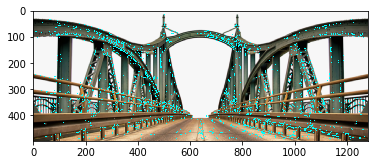

2
<class 'numpy.ndarray'>
octave number :  2


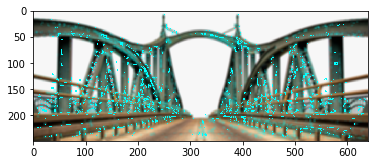

3
<class 'numpy.ndarray'>
octave number :  3


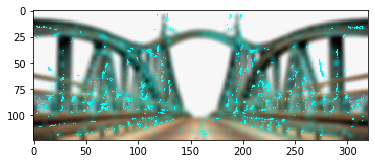

4
<class 'numpy.ndarray'>
octave number :  4


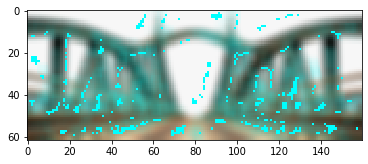

In [15]:
output_image = colour_image.copy()
scale = 1
sigma = 1.6
for each_octave in key_points:
    print(each_octave)
    output_image = cv2.resize(output_image, (int(scale*image.shape[1]), int(scale*image.shape[0])))
    output_image = cv2.GaussianBlur(output_image, (5,5), sigma)
    #output_image = resize_image(output_image,scale,sigma)
    print(type(output_image))
    final_points = []
    print("octave number : ", each_octave)
    for levels in key_points[each_octave]:
        #print(levels)
        final_points.extend(key_points[each_octave][levels])
    #print(final_points)
    for pts in final_points:
        x1,y1 = pts
        output_image.itemset((x1,y1,0),0)
        output_image.itemset((x1,y1,1),255)
        output_image.itemset((x1,y1,2),255)
    plt.imshow(output_image.astype('uint8'))
    plt.show()
    scale /= 2
    sigma = sigma*2
    #print(type(output_image))